<a href="https://colab.research.google.com/github/ibader85/UnstructuredDataAnalytics/blob/main/13_Advanced_Topics_Text_Analysis_using_SVM_Naieve_Bayes_Updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

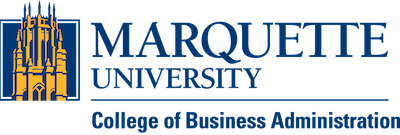

#BUAN4060: Unstructured Data Analytics

##13 Text Analysis using SVM & Naieve Bayes

##Instructor: Dr. Badar Al Lawati "Dr. B"

**Acknowledgment:** This material is based on the content created by [Alexandre KOWALCZYK](https://www.svm-tutorial.com/2014/11/svm-classify-text-r/)

**R on Colab:**

* You can change the runtime from Python to R, by clicking on the down arrow next to Connect, and picking "Change Runtime Type"

* You can change the project name by clicking on the title on top of this page

* You can export your notebook by going to File > Download .ipynb

# SVM Text Analysis

## 	1.	Install and Load Necessary Package:
To easily classify text with SVM,  we will use the [RTextTools package](http://cran.r-project.org/web/packages/RTextTools/RTextTools.pdf)

In [ ]:
# Install packages if needed
install.packages("RTextTools")

# Load libraries
library(RTextTools)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘iterators’, ‘NLP’, ‘slam’, ‘BH’, ‘proxy’, ‘prodlim’, ‘bitops’, ‘foreach’, ‘shape’, ‘RcppEigen’, ‘SparseM’, ‘randomForest’, ‘tree’, ‘tm’, ‘e1071’, ‘ipred’, ‘caTools’, ‘glmnet’, ‘tau’


Loading required package: SparseM



##	2.	Read the Data:
For this tutorial we will use a very simple data set [click to download](https://mega.co.nz/#!RINGEJKA!yrYFtfMPpLUOHye1YTC1SuYbAx6IKDJyG5uC_4N8R4M)

With just a few lines of R, we load the data in memory

In [ ]:
# Load the data from the csv file
data <- read.csv(paste('/content/sunnyData.csv', sep=""), header = TRUE)

head(data)

,Text,IsSunny
,<chr>,<int>
1,sunny,1
2,rainy,-1
3,sunny sunny,1
4,sunny rainy,-1
5,rainy sunny,-1
6,rainy rainy,-1


## 	3. Prepare the data:
The data has two columns: Text and IsSunny

We will need to convert it to a **Document Term Matrix**

Using RTextTools: The RTextTools package provides a powerful way to generate document term matrix with the create_matrix function

In [ ]:
# Create the document term matrix
dtMatrix <- create_matrix(data["Text"])

# View cleaned data
head(dtMatrix)

Warning message in TermDocumentMatrix.SimpleCorpus(x, control):
“custom functions are ignored”
Warning message in TermDocumentMatrix.SimpleCorpus(x, control):
“custom tokenizer is ignored”


<<DocumentTermMatrix (documents: 6, terms: 2)>>
Non-/sparse entries: 8/4
Sparsity           : 33%
Maximal term length: 5
Weighting          : term frequency (tf)

## 	4. Create and train the SVM model:
In order to train a SVM model with RTextTools, we need to put the document term matrix inside a container

In the container's configuration, we indicate that the whole data set will be the training set

In [ ]:
# Configure the training data
container <- create_container(dtMatrix, data$IsSunny, trainSize=1:11, virgin=FALSE)
# trainSize=1:11: Specifies the training set’s size by defining which rows (or indices) in dtMatrix should be used for training the model

# train a SVM Model
model <- train_model(container, "SVM", kernel="linear", cost=1)
# cost=1: This is a parameter for the SVM model that controls the trade-off between achieving a low training error and a low testing error
# The cost parameter (often called C in other implementations) determines the penalty for misclassifications
# A higher cost value will make the SVM model try harder to correctly classify all training data points,
# which can lead to overfitting, while a lower cost allows for more misclassifications in the training set

##5. Predict with new data

Now that our model is trained, we can use it to make new predictions !

We will create new sentences which were not in the training data:

In [ ]:
# new data
predictionData <- list("sunny sunny sunny rainy rainy", "rainy sunny rainy rainy", "hello", "", "this is another rainy world")

Before continuing, let's check the new sentences :

- "sunny sunny sunny rainy rainy"
This sentence talks more about the sunny weather than the rainy. We expect it to be classified as sunny (+1)
- "rainy sunny rainy rainy"
This sentence talks more about the rainy weather than the sunny. We expect it to be classified as rainy (-1)
- ""
This sentence has no word, it should return either +1 or -1 in function of the decision boundary
- "hello"
This sentence has a word which was not present in the training set. It will be equivalent to ""
- "this is another rainy world"
This sentence has several worlds not in the training set, and the word rainy. It is equivalent to the sentence "rainy" and should be classified "-1"

We create a document term matrix for the test data:

In [ ]:
# create a prediction document term matrix
predMatrix <- create_matrix(predictionData, originalMatrix=dtMatrix)

Warning message in TermDocumentMatrix.SimpleCorpus(x, control):
“custom functions are ignored”
Warning message in TermDocumentMatrix.SimpleCorpus(x, control):
“custom tokenizer is ignored”


Notice that this time we provided the originalMatrix as a parameter. This is because **we want the new matrix to use the same vocabulary as the training matrix**

Without this indication, the function will create a document term matrix using all the words of the test data (rainy, sunny, hello, this, is, another, world). It means that each sentence will be represented by a vector containing 7 values (one for each word) !

Such a matrix won't be compatible with the model we trained earlier because it expect vectors containing 2 values (one for rainy, one for sunny).

We now create the container:

In [ ]:
# create the corresponding container
predSize = length(predictionData);
# predSize calculates the number of documents (or observations) in predictionData, which represents the new data on which predictions will be made.

predictionContainer <- create_container(predMatrix, labels=rep(0,predSize), testSize=1:predSize, virgin=FALSE)
# when set to FALSE, ensures that the predMatrix retains the structure of the original training container without removing any unused terms from the model
# This maintains compatibility with the training model’s features

Two things are different:

- we use a zero vector for labels, because we want to predict them
- we specified **testSize** instead of **trainingSize** so that the data will be used for testing

Eventually, we can make predictions:

In [ ]:
# predict
results <- classify_model(predictionContainer, model)
results

,SVM_LABEL,SVM_PROB
,<chr>,<dbl>
1,1,0.7662103
2,-1,0.9319283
3,-1,0.5202077
4,-1,0.5202077
5,-1,0.7939308


As expected the first sentence has been classified as sunny and the second and last one as rainy.

We can also see that the third and fourth sentences  ("hello" and "") have been classified as rainy, but the probability is only  52% which means our model is not very confident on these two predictions

# Text Classification with Naive Bayes

**Acknowledgment:** This material is based on the content created by [Dhruvin Shah](https://rpubs.com/drshah96/629986)

The technique descended from the work of the 18th century mathematician Thomas Bayes, who developed foundational mathematical principles (now known as Bayesian methods) for describing the probability of events, and how probabilities should be revised in light of additional information

##1. Dataset Retrieval & Cleanup:

The Dataset is a subset of RCV1 (Lewis, Yang, Rose, & and Li, 2004), a text categorization test collection dataset developed by ZhiLiu and was donated on September 08, 2011 (ZhiLiu, 2011). The dataset is composed of Top 50 Authors and Top 100 texts of the Authors and Testing Data. So, a data with 5000 instances and is divided into 2 parts: Training and Testing. The training corpus consists of 2,500 texts (50 per author) and the test corpus includes other 2,500 texts (50 per author) non-overlapping with the training texts (ZhiLiu, 2011).

Attributes Information:

The dataset contains two attributes: author name and text. The author name contains 50 attribute specifies the text written by them. The text attribute contains the unprocessed text. The dataset consists total of 5000 instances.

In [1]:
#Downloading Dataset
if(!file.exists("reuter+50+50.zip")){
        #Downloading File
        download.file(url = "https://archive.ics.uci.edu/static/public/217/reuter+50+50.zip",
                      destfile = "/content/reuter+50+50.zip")

        #Unzipping the File
        unzip("/content/reuter+50+50.zip", exdir = "/content/reuter+50+50/")
}

In [4]:
# Run the system commands in R
system("apt-get update")
system("apt-get install -y libpoppler-cpp-dev")

In [5]:
#Reading Data
install.packages("pdftools")
install.packages("readtext")
install.packages("readtext")
library(readtext)

#Train Data File
data_train_dir <- system.file("/content/reuter+50+50/C50train")
Data_train <- readtext(paste0(data_train_dir, "/content/reuter+50+50/C50train/*"),
                       dvsep = "\n")
head(Data_train$text, n = 1)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



[1] "The Internet may be overflowing with new technology but crime in cyberspace is still of the old-fashioned variety.\nThe National Consumers League said Wednesday that the most popular scam on the Internet was the pyramid scheme, in which early investors in a bogus fund are paid off with deposits of later investors.\nThe league, a non-profit consumer advocacy group, tracks web scams through a site it set up on the world wide web in February called Internet Fraud Watch at http://www.fraud.org.\nThe site, which collects reports directly from consumers, has been widely praised by law enforcement agencies.\n\"Consumers who suspect a scam on the Internet have critical information,\" said Jodie Bernstein, director of the Federal Trade Commission's Bureau of Consumer Protection. Internet Fraud Watch \"has been a major help to the FTC in identifying particular scams in their infancy.\"\nIn May, for example, the commission used Internet reports to shut down a site run by Fortuna Alliance that had taken in over $6 million, promising investors they could earn $5,000 a month from an initial deposit of $250. Instead, Fortuna kept most of the money, the commission charged.\nFraud reports from the league's site, which has been visited over 370,000 times, are forwarded to local, state and federal authorities.\nThe second-most-popular Internet scam, the league said, was the sale of bogus Internet services, such as custom designed web sites or Internet access accounts.\nIn third place were crooks who sell computer equipment, such as memory chips or sound boards, over the net and then deliver significantly lower quality goods or nothing at all, the league said.\nOther top scams involve business opportunities. Con artists may offer shares in a business or franchise using unreasonable predictions or misrepresentations. One popular scheme promised to let consumers get rich while working at home.\nThe League also announced Tuesday that NationsBank had donated $100,000 to become a sponsor of the Fraud Watch site."

In [6]:
#Test Data File
data_test_dir <- system.file("/content/reuter+50+50/C50test")
Data_test <- readtext(paste0(data_test_dir, "/content/reuter+50+50/C50test/*"),
                      dvsep = "\n")

#Author Names
Authornames <- as.data.frame(rep(basename(list.dirs("/content/reuter+50+50/C50train")), each = 50))
Authornames <- Authornames[-(1:50),]

#Assigning Author name to Text
Data_test$Author <- Authornames
Data_train$Author <- Authornames

#Dropping ID Column
Data_test <- Data_test[-1]
Data_train <- Data_train[-1]

#Converting Author Column to Factor
Data_test$Author <- as.factor(Data_test$Author)
Data_train$Author <- as.factor(Data_train$Author)

#Filtering Data by 4 Authors
install.packages("dplyr")
install.packages("data.table")

library(dplyr)
library(data.table)

AaronTrain <- Data_train %>% filter(Author == "AaronPressman", text == text)
JaneTrain <- Data_train %>% filter(Author == "JaneMacartney", text == text)
SarahTrain <- Data_train %>% filter(Author == "SarahDavison", text == text)
WilliamTrain <- Data_train %>% filter(Author == "WilliamKazer", text == text)
Data_train <- rbind(AaronTrain, JaneTrain, SarahTrain, WilliamTrain)

AaronTest <- Data_test %>% filter(Author == "AaronPressman", text == text)
JaneTest <- Data_test %>% filter(Author == "JaneMacartney", text == text)
SarahTest <- Data_test %>% filter(Author == "SarahDavison", text == text)
WilliamTest <- Data_test %>% filter(Author == "WilliamKazer", text == text)
Data_test <- rbind(AaronTest, JaneTest, SarahTest, WilliamTest)

dim(Data_test)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last




[1] 200   2

In [7]:
dim(Data_train)

[1] 200   2

In [8]:
table(Data_train$Author)


    AaronPressman        AlanCrosby    AlexanderSmith   BenjaminKangLim 
               50                 0                 0                 0 
    BernardHickey       BradDorfman  DarrenSchuettler       DavidLawder 
                0                 0                 0                 0 
    EdnaFernandes       EricAuchard    FumikoFujisaki    GrahamEarnshaw 
                0                 0                 0                 0 
 HeatherScoffield     JaneMacartney        JanLopatka      JimGilchrist 
                0                50                 0                 0 
         JoeOrtiz      JohnMastrini      JonathanBirt    JoWinterbottom 
                0                 0                 0                 0 
      KarlPenhaul         KeithWeir    KevinDrawbaugh     KevinMorrison 
                0                 0                 0                 0 
    KirstinRidley KouroshKarimkhany         LydiaZajc    LynneO'Donnell 
                0                 0               

##2. Exploring and Preparing Data

As a part of Exploratory Data Analysis, I found that there are no missing values in the dataset

In [11]:
#Checking for missing values
any(is.na(Data_train))
any(is.na(Data_test))

[1] FALSE

[1] FALSE

To analyze the textdata, the first step involves creating a corpus, which refers to a collection of text documents. The Corpus was created from the dataset using Corpus() function of “tm” package of R. It creates the R object to store text documents

The Corpus data was then cleaned using “tm_map()” function. For cleaning the corpus, the text was converted to lower case using “tolower” attribute of tm_map. Then using “removeNumbers”, “removeWords”, “stopwords()” as well as “stripWhitespace” functions, the number, stopping words and white spaces were removed. The figure shows the clean corpus element 1 of Training Dataset

In [12]:
install.packages("tm")
library(tm)

#Creating Corpus
suppressWarnings(Data_test_corpus <- Corpus(VectorSource(Data_test$text)))
suppressWarnings(Data_train_corpus <- Corpus(VectorSource(Data_train$text)))

#Corpus Cleaning
suppressWarnings(Data_test_corpus_clean <- tm_map(Data_test_corpus, tolower))
suppressWarnings(Data_train_corpus_clean <- tm_map(Data_train_corpus, tolower))

suppressWarnings(Data_test_corpus_clean <- tm_map(Data_test_corpus_clean, removeNumbers))
suppressWarnings(Data_train_corpus_clean <- tm_map(Data_train_corpus_clean, removeNumbers))

suppressWarnings(Data_test_corpus_clean <- tm_map(Data_test_corpus_clean, removeWords, stopwords()))
suppressWarnings(Data_train_corpus_clean <- tm_map(Data_train_corpus_clean, removeWords, stopwords()))

suppressWarnings(Data_test_corpus_clean <- tm_map(Data_test_corpus_clean, removePunctuation))
suppressWarnings(Data_train_corpus_clean <- tm_map(Data_train_corpus_clean, removePunctuation))

suppressWarnings(Data_test_corpus_clean <- tm_map(Data_test_corpus_clean, stripWhitespace))
suppressWarnings(Data_train_corpus_clean <- tm_map(Data_train_corpus_clean, stripWhitespace))

suppressWarnings(inspect(Data_train_corpus_clean[1]))

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘NLP’, ‘slam’, ‘BH’


Loading required package: NLP



<<SimpleCorpus>>
Metadata:  corpus specific: 1, document level (indexed): 0
Content:  documents: 1

[1]  internet may overflowing new technology crime cyberspace still oldfashioned variety national consumers league said wednesday popular scam internet pyramid scheme early investors bogus fund paid deposits later investors league nonprofit consumer advocacy group tracks web scams site set world wide web february called internet fraud watch httpwwwfraudorg site collects reports directly consumers widely praised law enforcement agencies consumers suspect scam internet critical information said jodie bernstein director federal trade commissions bureau consumer protection internet fraud watch major help ftc identifying particular scams infancy may example commission used internet reports shut site run fortuna alliance taken million promising investors earn month initial deposit instead fortuna kept money commission charged fraud reports leagues site visited times forwarded local state feder

The text from Training Dataset was split according to authors. Using the “wordcloud” package of R, the most used words by authors were visualized

The following word cloud is the visualization of most frequently used words in by author in test and training database

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: RColorBrewer



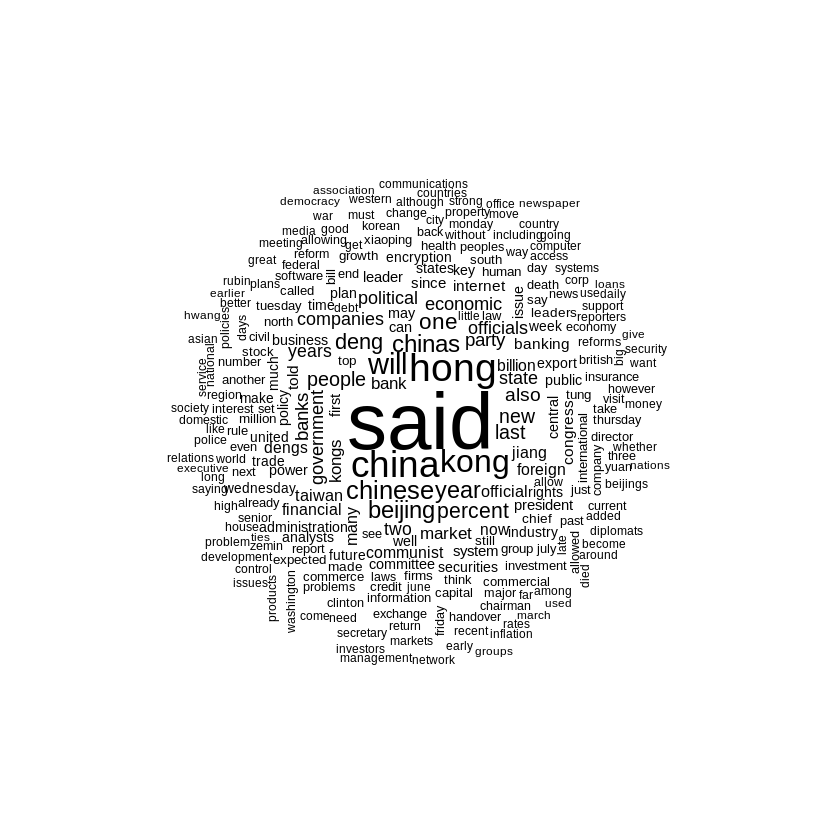

In [14]:
#Word Cloud of Testing Dataset
install.packages("wordcloud")
library(wordcloud)
wordcloud(Data_test_corpus_clean, min.freq = 40, random.order = FALSE)

The data is then split into individual components commonly known as tokenization

The token was achieved using “DocumentTermMatrix()” function of “tm” package

This will create a data structure called Sparse Matrix in which rows indicate the Text and Column represents the word.

In [15]:
#Sparse Matrix
test_dtm <- DocumentTermMatrix(Data_test_corpus_clean)
train_dtm <- DocumentTermMatrix(Data_train_corpus_clean)

inspect(train_dtm)

<<DocumentTermMatrix (documents: 200, terms: 8765)>>
Non-/sparse entries: 41629/1711371
Sparsity           : 98%
Maximal term length: 36
Weighting          : term frequency (tf)
Sample             :
     Terms
Docs  china chinese hong kong last one percent said will year
  126     0       0    3    3    1   1       1   13    3    1
  127     4       1    2    2    3   3       7    5   11    6
  133     1       0    3    3    2   2       5    7    3    3
  137     1       6   12   11    1   5       0   12    3    3
  139     0       1    2    2    6   1      14   23    9    1
  140    17       4   27   19    1   6       3   12   15    2
  51      2       3    0    0    1   5       1   17    0    6
  53      2      14    0    0    1   4       1    6    0    2
  55      1       1    0    0    2   0       2   16    2    4
  60      3       4    0    0    2   5       4    9    0    6


To predict the model using Naive Bayes Classification, the training and testing datasets are obtained using frequency of words

In [16]:
##### Preparing Training and Testing Datasets #####
### Creating Indicator features for frequent words ###
FreqWords <- findFreqTerms(train_dtm, 5)

#Saving List using Dictionary() Function
Dictionary <- function(x) {
        if( is.character(x) ) {
                return (x)
        }
        stop('x is not a character vector')
}

data_dict <- Dictionary(findFreqTerms(train_dtm, 5))

#Appending Document Term Matrix to Train and Test Dataset
data_train <- DocumentTermMatrix(Data_train_corpus_clean, list(data_dict))
data_test <- DocumentTermMatrix(Data_test_corpus_clean, list(data_dict))

#Converting the frequency of word to count
convert_counts <- function(x) {
        x <- ifelse(x > 0, 1, 0)
        x <- factor(x, levels = c(0, 1), labels = c("No", "Yes"))
        return(x)
}

#Appending count function to Train and Test Dataset
data_train <- apply(data_train, MARGIN = 2, convert_counts)
data_test <- apply(data_test, MARGIN = 2, convert_counts)

## 3. Training a Model

In [18]:
#Naive Bayes Classification
install.packages("e1071")
library(e1071)
data_classifier <- naiveBayes(data_train, Data_train$Author)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘proxy’




##4. Evaluating Model Performance

In [19]:
install.packages("gmodels")
library(gmodels)
data_test_pred <- predict(data_classifier, data_test)
CrossTable(data_test_pred, Data_test$Author,
           prop.chisq = FALSE, prop.t = FALSE,
           dnn = c('predicted', 'actual'))

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘gtools’, ‘gdata’





 
   Cell Contents
|-------------------------|
|                       N |
|           N / Row Total |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  200 

 
              | actual 
    predicted | AaronPressman | JaneMacartney |  SarahDavison |  WilliamKazer |     Row Total | 
--------------|---------------|---------------|---------------|---------------|---------------|
AaronPressman |            46 |             0 |             0 |             0 |            46 | 
              |         1.000 |         0.000 |         0.000 |         0.000 |         0.230 | 
              |         0.920 |         0.000 |         0.000 |         0.000 |               | 
--------------|---------------|---------------|---------------|---------------|---------------|
JaneMacartney |             0 |            40 |             2 |            14 |            56 | 
              |         0.000 |         0.714 |         0.036 |         0.250 |         0.280 | 
 

From the table we can observe that the accuracy achieved is 83.0%.

## 5. Improving Model Performance
Setting Laplace = 1 is one way for improving performance of model

In [20]:
# Setting Laplace = 1
library(e1071)
data_classifier2 <- naiveBayes(data_train, Data_train$Author,laplace = 1)

library(gmodels)
data_test_pred2 <- predict(data_classifier2, data_test)
CrossTable(data_test_pred2, Data_test$Author,
           prop.chisq = FALSE, prop.t = FALSE,
           dnn = c('predicted', 'actual'))


 
   Cell Contents
|-------------------------|
|                       N |
|           N / Row Total |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  200 

 
              | actual 
    predicted | AaronPressman | JaneMacartney |  SarahDavison |  WilliamKazer |     Row Total | 
--------------|---------------|---------------|---------------|---------------|---------------|
AaronPressman |            49 |             0 |             0 |             0 |            49 | 
              |         1.000 |         0.000 |         0.000 |         0.000 |         0.245 | 
              |         0.980 |         0.000 |         0.000 |         0.000 |               | 
--------------|---------------|---------------|---------------|---------------|---------------|
JaneMacartney |             0 |            30 |             1 |             9 |            40 | 
              |         0.000 |         0.750 |         0.025 |         0.225 |         0.200 | 
 

From the table we can observe that with laplace equals to 1, the accuracy achieved is 80.5%.

## Summary
- This algorithm constructs tables of probabilities that are used to estimate the likelihood that new examples belong to various classes
- The original model is 2.5% more accurate than model with Laplace = 1
- In Base Model, 34 text were misclassified while in model with Laplace = 1, 39 text out of 200 were wrongly classified constituting 19.5% of the dataset
- The Model Optimization technique failed in this dataset might be because of less instances